In [1]:
import sys
sys.path.insert(0, "../../")
from classes.calculators.lennardjones import LennardJones
from classes.atom_classes.atom_collection import Atom_Collection
from classes.atom_classes.atom import Atom
from classes.atom_classes.atom_collection_plotter import Atom_Collection_Plotter
from classes.optimizers.metropol import Metropol_new1 as Metropol
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
plt.rc('animation', html='jshtml')

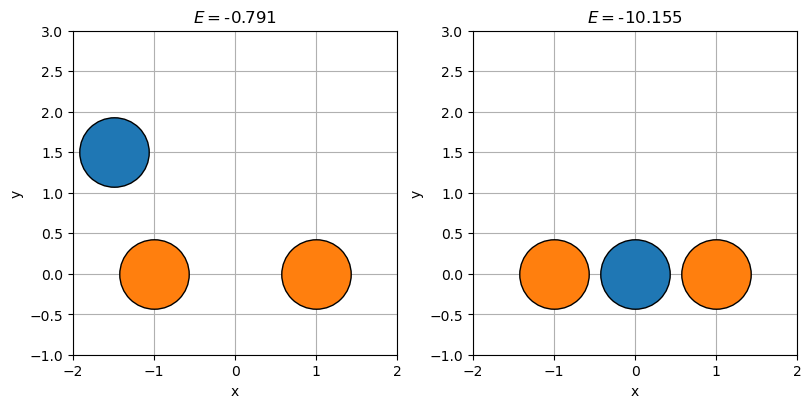

In [2]:
fig, axs = plt.subplots(1,2,figsize=(8,4), layout="constrained")
colors = ["C0", "C1", "C1"]
atomlist = []
positions = [np.array([-1.5,1.5]), np.array([-1.0,0.0]), np.array([1.0,0.0])]
frozens = [False, True, True]
for position, frozen in zip(positions, frozens):
    atom = Atom(position=position, frozen=frozen)
    atomlist.append(atom)

atom_col1 = Atom_Collection(atomlist=atomlist)
atom_col1.calculator = LennardJones()
atomlist = []
positions = [np.array([0.0,0.0]), np.array([-1.0,0.0]), np.array([1.0,0.0])]
frozens = [False, True, True]
for position, frozen in zip(positions, frozens):
    atom = Atom(position=position, frozen=frozen)
    atomlist.append(atom)

atom_col2 = Atom_Collection(atomlist=atomlist)
atom_col2.calculator = LennardJones()
atom_cols = [atom_col1, atom_col2]

atom_plotter = Atom_Collection_Plotter()

for ax, atom_col in zip(axs, atom_cols):
    ax.set_xlim([-2.0,2.0])
    ax.set_ylim([-1.0,3.0])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    E = atom_col.get_potential_energy()
    ax.set_title(rf"$E=${E.round(3)}")
    atom_plotter(atom_col=atom_col, ax=ax)
    ax.grid()

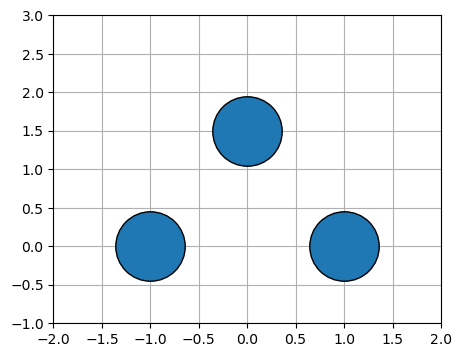

In [3]:
atomlist = []
positions = [np.array([-1.5,-1.5]), np.array([-1.0,0.0]), np.array([1.0,0.0]), np.array([0.0, 1.5])]
colors = ["C0", "C1", "C1", "C1"]
fig, ax = plt.subplots(figsize=(5,4))
ax.set_xlim([-2.0,2.0])
ax.set_ylim([-1.0,3.0])
for position, color in zip(positions, colors):
    atom = Atom(position=position)
    atomlist.append(atom)
ax.grid()
atom_col = Atom_Collection(atomlist=atomlist)
atom_col.calculator = LennardJones()
atom_plotter(atom_col=atom_col, ax = ax)
E_lim = 5.0
xs = np.linspace(-3.0, 3.0, 200)
ys = np.linspace(-3.0, 3.0, 200)
energies = np.zeros(shape=(len(ys), len(xs)))
for i, x in enumerate(xs):
    for j, y in enumerate(ys):
        atom_col.set_atom_pos(index=0, pos=np.array([x, y]))
        E = atom_col.get_potential_energy()
        if E > E_lim:
            energies[j][i] = E_lim #WE SET LARGE VALUES TO CAP AT E_lim
        else:
            energies[j][i] = E
atom_col.positions[0] = positions[0]

In [4]:
atoms_for_freeze = [1,2,3]
atom_col.freeze_atoms(indices=atoms_for_freeze)
optimizer = Metropol(atom_col=atom_col, T=0.15)
optimizer.run_all_atoms(E_limit=-15.5, track=True, start_quench=200, N_max=1000)
single_atom_steps = []
pot_es = []
for opt_col in optimizer.logged_atom_cols:
    opt_col.calculator = LennardJones()
    pot_es.append(opt_col.get_potential_energy())
    pos = opt_col.positions[0]
    single_atom_steps.append(pos)
single_atom_steps = np.array(single_atom_steps)

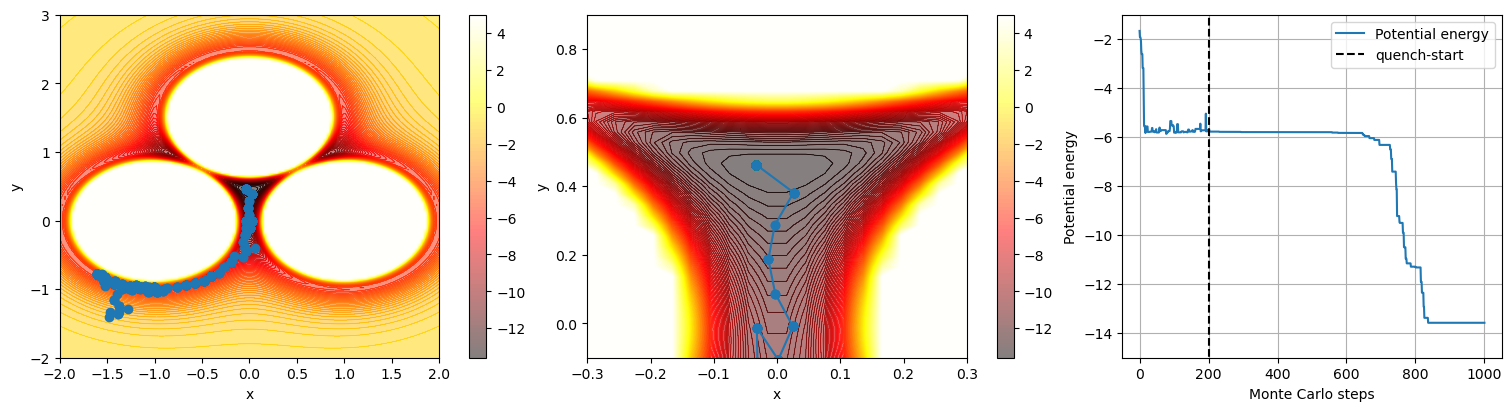

In [5]:
fig, axs = plt.subplots(1,3,figsize=(15,4), layout="constrained")
axs[0].set_xlim([-2.0,2.0])
axs[0].set_ylim([-2.0,3.0])
axs[1].set_xlim([-0.3,0.3])
axs[1].set_ylim([-0.1,0.9])

for ax in axs[0:2]:
    ax.set_xlabel("x")
    ax.set_ylabel("y")

Xi, Yi = np.meshgrid(xs, xs)
axs[2].plot(np.linspace(0, len(pot_es), len(pot_es)), pot_es, label="Potential energy")
axs[2].vlines(200, -20, -1, colors="k", ls="--", label="quench-start")
axs[2].set_ylim([-15.0, -1])
axs[2].grid()
axs[2].set_xlabel("Monte Carlo steps")
axs[2].set_ylabel("Potential energy")
axs[2].legend()
cmap = "hot"
for ax in axs[0:2]:
    ax.contour(Xi, Yi, energies, levels=100, linewidths=0.5, cmap=cmap)
    cntr1 = ax.contourf(Xi, Yi, energies, levels=100, cmap=cmap, alpha=0.5)
    ax.plot(single_atom_steps[:,0], single_atom_steps[:,1], "o-")
    fig.colorbar(cntr1, ax=ax)